## 概述

现代数据天气预报(numerical weather prediction, NWP)可以追溯到1920年，其基于物理原理，整合了几代气象学者的成果经验，是各国气象部门所采用主流的天气预报方法。其中来自欧洲中期天气预报中心(ECMWF)的高分辨率综合系统模型(IFS)表现效果最佳.

本团队利用NVIDIA提出的SHT（球谐波变换）算子与本团队开发的KNO算法相结合，提出了一套气象预测的算法。能够在6小时间隔、1.4度的分辨率上对全球关键天气指标进行预测。该算法在中长期气象预测上具有很大优势。SHT算子的详细信息可以参考：- ["Spherical Fourier Neural Operators:Learning Stable Dynamics on the Sphere"](https://arxiv.org/pdf/2306.03838.pdf) arXiv:2306.03838

以往的气象预测模型都将气象数据视为一个平面结构进行处理。在短期预测时，这种设计能对气象数据进行很好的拟合。但是，当预测的时间增加后，以往的工作在视觉和光谱上会出现明显的尾影，使得预测的结果与真实结果存在较大的差异。因此，本项目将气象数据视为一个球面，采用SHT算子对KNO模型中编码的气象数据进行处理。通过球谐波变换的拟合，本项目在中长期预报上，对以往的工作具有很大的优势。

## 问题描述

本案例将SKNO应用于气象领域，显著提升了长期天气预报的准确度。

## 技术路径

MindEarth求解该问题的具体流程如下：

1. 模型构建
2. 损失函数
3. 模型训练
4. 模型验证和可视化

## SKNO

SKNO模型主要由三部分组成，分别是Encoder、SKNOBlock、Decoder。在模型中，输入的数据先通过Encoder进行编码，编码后的特征利用SKNOBlock进行特征增强和学习，增强后的特征利用Decoder进行解码还原。

![SKNO](./images/SKNO.PNG "Model")

模型的训练流程如下

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mindspore import context, Model
from mindspore import dtype as mstype
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.loss_scale_manager import DynamicLossScaleManager
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data, make_dir
from mindearth.module import Trainer
from mindearth.data import Dataset, Era5Data, SIZE_DICT

from src.skno import SKNO
from src.callback import EvaluateCallBack, InferenceModule, CustomWithLossCell, Lploss

[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:46.429.000 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:46.432.000 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:46.433.000 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. F

 `src` 文件可以从 `MindEarth/applications/SKNO/src`下载.

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=5)

[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:52.180.00 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:52.200.00 [mindspore/run_check/_check_version.py:462] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:12:52.210.00 [mindspore/run_check/_check_version.py:469] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. For 

In [ ]:
config = load_yaml_config('./configs/skno.yaml')
config['model']['data_sink'] = True

config['train']['distribute'] = False
config['train']['amp_level'] = 'O2'

config['data']['num_workers'] = 8
config['data']['grid_resolution'] = 1.4
config['data']['h_size'], config['data']['w_size'] = SIZE_DICT[1.4]

config['optimizer']['epochs'] = 200
config['optimizer']['finetune_epochs'] = 1
config['optimizer']['warmup_epochs'] = 1
config['optimizer']['initial_lr'] = 1e-4

config['summary']["valid_frequency"] = 10
config['summary']["summary_dir"] = './summary'
make_dir(os.path.join(config['summary']["summary_dir"], "image"))
logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

model、data和optimizer的参数可以通过 `config`获取.

## 模型构建

模型的计算流程：

- 分支一 （Prediction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 编码后的数据在SKNO blocks进行球谐波变换，并在频域进行非线性变换。
    3. Decoder模块对SKNO blocks输出的数据进行还原，得到最终预测输出

- 分支二 （Reconstruction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 将Encoder模块的输出作为Decoder模块的输入，实现对输入数据的重建。

In [4]:
data_params = config['data']
model_params = config['model']
compute_type = mstype.float32
model = SKNO(image_size=(data_params["h_size"], data_params["w_size"]),
             in_channels=data_params["feature_dims"],
             out_channels=data_params["feature_dims"],
             patch_size=data_params["patch_size"],
             encoder_depths=model_params["encoder_depth"],
             encoder_embed_dims=model_params["encoder_embed_dim"],
             mlp_ratio=model_params["mlp_ratio"],
             dropout_rate=model_params["dropout_rate"],
             num_blocks=model_params["num_blocks"],
             high_freq=True,
             encoder_network=model_params["encoder_network"],
             compute_dtype=compute_type)

[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:04.658.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:04.931.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:05.685.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:05.775.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:05.864.000 [mindspore/nn/layer/basic.py:177] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364

## 损失函数

SKNO使用多loss的训练方法，包括Prediction loss，Reconstruction loss，两者均基于mean squared error。

In [ ]:
loss_fn = Lploss()
loss_net = CustomWithLossCell(model, loss_fn)

## 模型训练

模型训练阶段继承了Trainer类，同时重写了get_callback，get_solver两个成员函数，以便于能在训练阶段执行测试验证；

In [ ]:
class SKNOEra5Data(Era5Data):
    def _patch(self, *args):
        """ Partition the data into patches. """
        if self.run_mode == 'valid' or self.run_mode == 'test':
            x = args[0]
            x = args[0].transpose(1, 0, 2, 3)
        return x



class SKNOTrainer(Trainer):
    """
    Self-define forecast model inherited from `Trainer`.

    Args:
        config (dict): parameters for training.
        model (Cell): network for training.
        loss_fn (str): user-defined loss function.
        logger (logging.RootLogger): tools for logging.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """

    def __init__(self, config, model, loss_fn, logger):
        super(SKNOTrainer, self).__init__(config, model, loss_fn, logger)
        self.pred_cb = self.get_callback()

    def get_data_generator(self):
        """
        Get train and valid dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = Era5Data(data_params=self.data_params, run_mode='train', kno_patch=True)
        valid_dataset_generator = Era5Data(data_params=self.data_params, run_mode='valid')
        return train_dataset_generator, valid_dataset_generator

    def get_callback(self):
        """
        define the callback of the model, abstract method.
        """
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset_generator, self.config, self.logger)
        return pred_cb

    def get_solver(self):
        """
        define the solver of the model, abstract method.
        """
        loss_scale = DynamicLossScaleManager()
        solver = Model(self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params['amp_level']
                       )
        return solver

trainer = SKNOTrainer(config, model, loss_net, logger)

2024-11-30 15:13:13,948 - pretrain.py[line:229] - INFO: steps_per_epoch: 404


### 模型训练

In [7]:
trainer.train()

[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-10:43:13.357.000 [mindspore/train/model.py:1328] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-10:43:13.787.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-10:43:13.789.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-10:43:13.790.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-10:43:13.791.000 [mindspore/nn/layer/basic.py:203] For Dropout,

epoch: 1 step: 404, loss is 0.304
Train epoch time: 221822.418 ms, per step time: 549.065 ms
epoch: 2 step: 404, loss is 0.2365
Train epoch time: 132110.393 ms, per step time: 327.006 ms
epoch: 3 step: 404, loss is 0.2247
Train epoch time: 131904.142 ms, per step time: 326.495 ms
epoch: 4 step: 404, loss is 0.2072
Train epoch time: 132006.532 ms, per step time: 326.749 ms
epoch: 5 step: 404, loss is 0.2002
Train epoch time: 133064.870 ms, per step time: 329.368 ms
epoch: 6 step: 404, loss is 0.1941
Train epoch time: 131677.289 ms, per step time: 325.934 ms
epoch: 7 step: 404, loss is 0.1827
Train epoch time: 131201.390 ms, per step time: 324.756 ms
epoch: 8 step: 404, loss is 0.1837
Train epoch time: 131637.308 ms, per step time: 325.835 ms
epoch: 9 step: 404, loss is 0.1803
Train epoch time: 131752.106 ms, per step time: 326.119 ms
epoch: 10 step: 404, loss is 0.1703
Train epoch time: 133501.462 ms, per step time: 330.449 ms


2024-11-30 11:06:44,047 - forecast.py[line:221] - INFO: ================================Start Evaluation================================
2024-11-30 11:06:44,048 - forecast.py[line:222] - INFO: test dataset size: 9
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-11:06:44.482.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-11:06:44.483.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-11:06:44.484.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(947384:281472867393568,MainProcess):2024-11-30-11:06:44.485.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNI

PREDICTION TIME: 42.78314161300659 s
COMPUTE RMSE AND ACC TIME: 0.23354482650756836 s
PREDICTION TIME: 2.15376877784729 s
COMPUTE RMSE AND ACC TIME: 0.22422361373901367 s
PREDICTION TIME: 2.146989107131958 s
COMPUTE RMSE AND ACC TIME: 0.22658658027648926 s
PREDICTION TIME: 2.1528539657592773 s
COMPUTE RMSE AND ACC TIME: 0.21991634368896484 s
PREDICTION TIME: 2.144331216812134 s
COMPUTE RMSE AND ACC TIME: 0.23775601387023926 s
PREDICTION TIME: 2.141766309738159 s
COMPUTE RMSE AND ACC TIME: 0.2419605255126953 s
PREDICTION TIME: 2.1450841426849365 s
COMPUTE RMSE AND ACC TIME: 0.21451950073242188 s
PREDICTION TIME: 2.1464078426361084 s
COMPUTE RMSE AND ACC TIME: 0.22919011116027832 s
PREDICTION TIME: 2.14589524269104 s


2024-11-30 11:07:49,827 - forecast.py[line:327] - INFO: t = 6 hour: 
2024-11-30 11:07:49,828 - forecast.py[line:329] - INFO:  RMSE of Z500: 195.73384089253435, T2m: 2.423350078014815, T850: 1.5194845309981444, U10: 1.4497637099702967
2024-11-30 11:07:49,829 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.9901990971896727, T2m: 0.9681767978922511, T850: 0.9680201685322274, U10: 0.9695553422783411
2024-11-30 11:07:49,830 - forecast.py[line:327] - INFO: t = 72 hour: 
2024-11-30 11:07:49,831 - forecast.py[line:329] - INFO:  RMSE of Z500: 750.8704188610463, T2m: 4.425397106277199, T850: 3.7921919735530714, U10: 3.793785323137186
2024-11-30 11:07:49,832 - forecast.py[line:333] - INFO:  ACC  of Z500: 0.859221621317006, T2m: 0.8879913146819198, T850: 0.7841260983978134, U10: 0.7814183452875749
2024-11-30 11:07:49,833 - forecast.py[line:327] - INFO: t = 120 hour: 
2024-11-30 11:07:49,834 - forecast.py[line:329] - INFO:  RMSE of Z500: 982.8974722311274, T2m: 5.129292151440555, T850: 4.936718031

COMPUTE RMSE AND ACC TIME: 0.23601555824279785 s


### 模型推理及可视化


In [ ]:
pred_time_index = 0
class SKNOInferenceModule(InferenceModule):
    def forecast(self, inputs):
        pred_lst = []
        for _ in range(self.t_out):
            pred, _ = self.model(inputs)
            pred_lst.append(pred.asnumpy())
            inputs = pred
        return pred_lst

params = load_checkpoint('./summary/ckpt/step_1/SKNO-10_51.ckpt')
load_param_into_net(model, params)
inference_module = SKNOInferenceModule(model, config, logger)

In [8]:
def plt_data(pred, label, root_dir, index=0):
    """ Visualize the forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))

    plt.figure(num='e_imshow', figsize=(100, 50), dpi=50)

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error')  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error')  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True)  # T2M

    plt.savefig(f'pred_result.png', bbox_inches='tight')
    plt.show()

[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.740.00 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.760.00 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.770.00 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.780.00 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.790.00 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:2814

inputs (1, 69, 128, 256)
labels (1, 69, 20, 128, 256)


[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:29.318.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:30.499.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:30.516.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:30.620.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:30.887.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364

[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:52.124.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:52.125.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:52.126.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:52.127.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364:281472959283232,MainProcess):2024-11-30-15:13:52.128.000 [mindspore/nn/layer/basic.py:203] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(1585364

pred (1, 69, 128, 256)


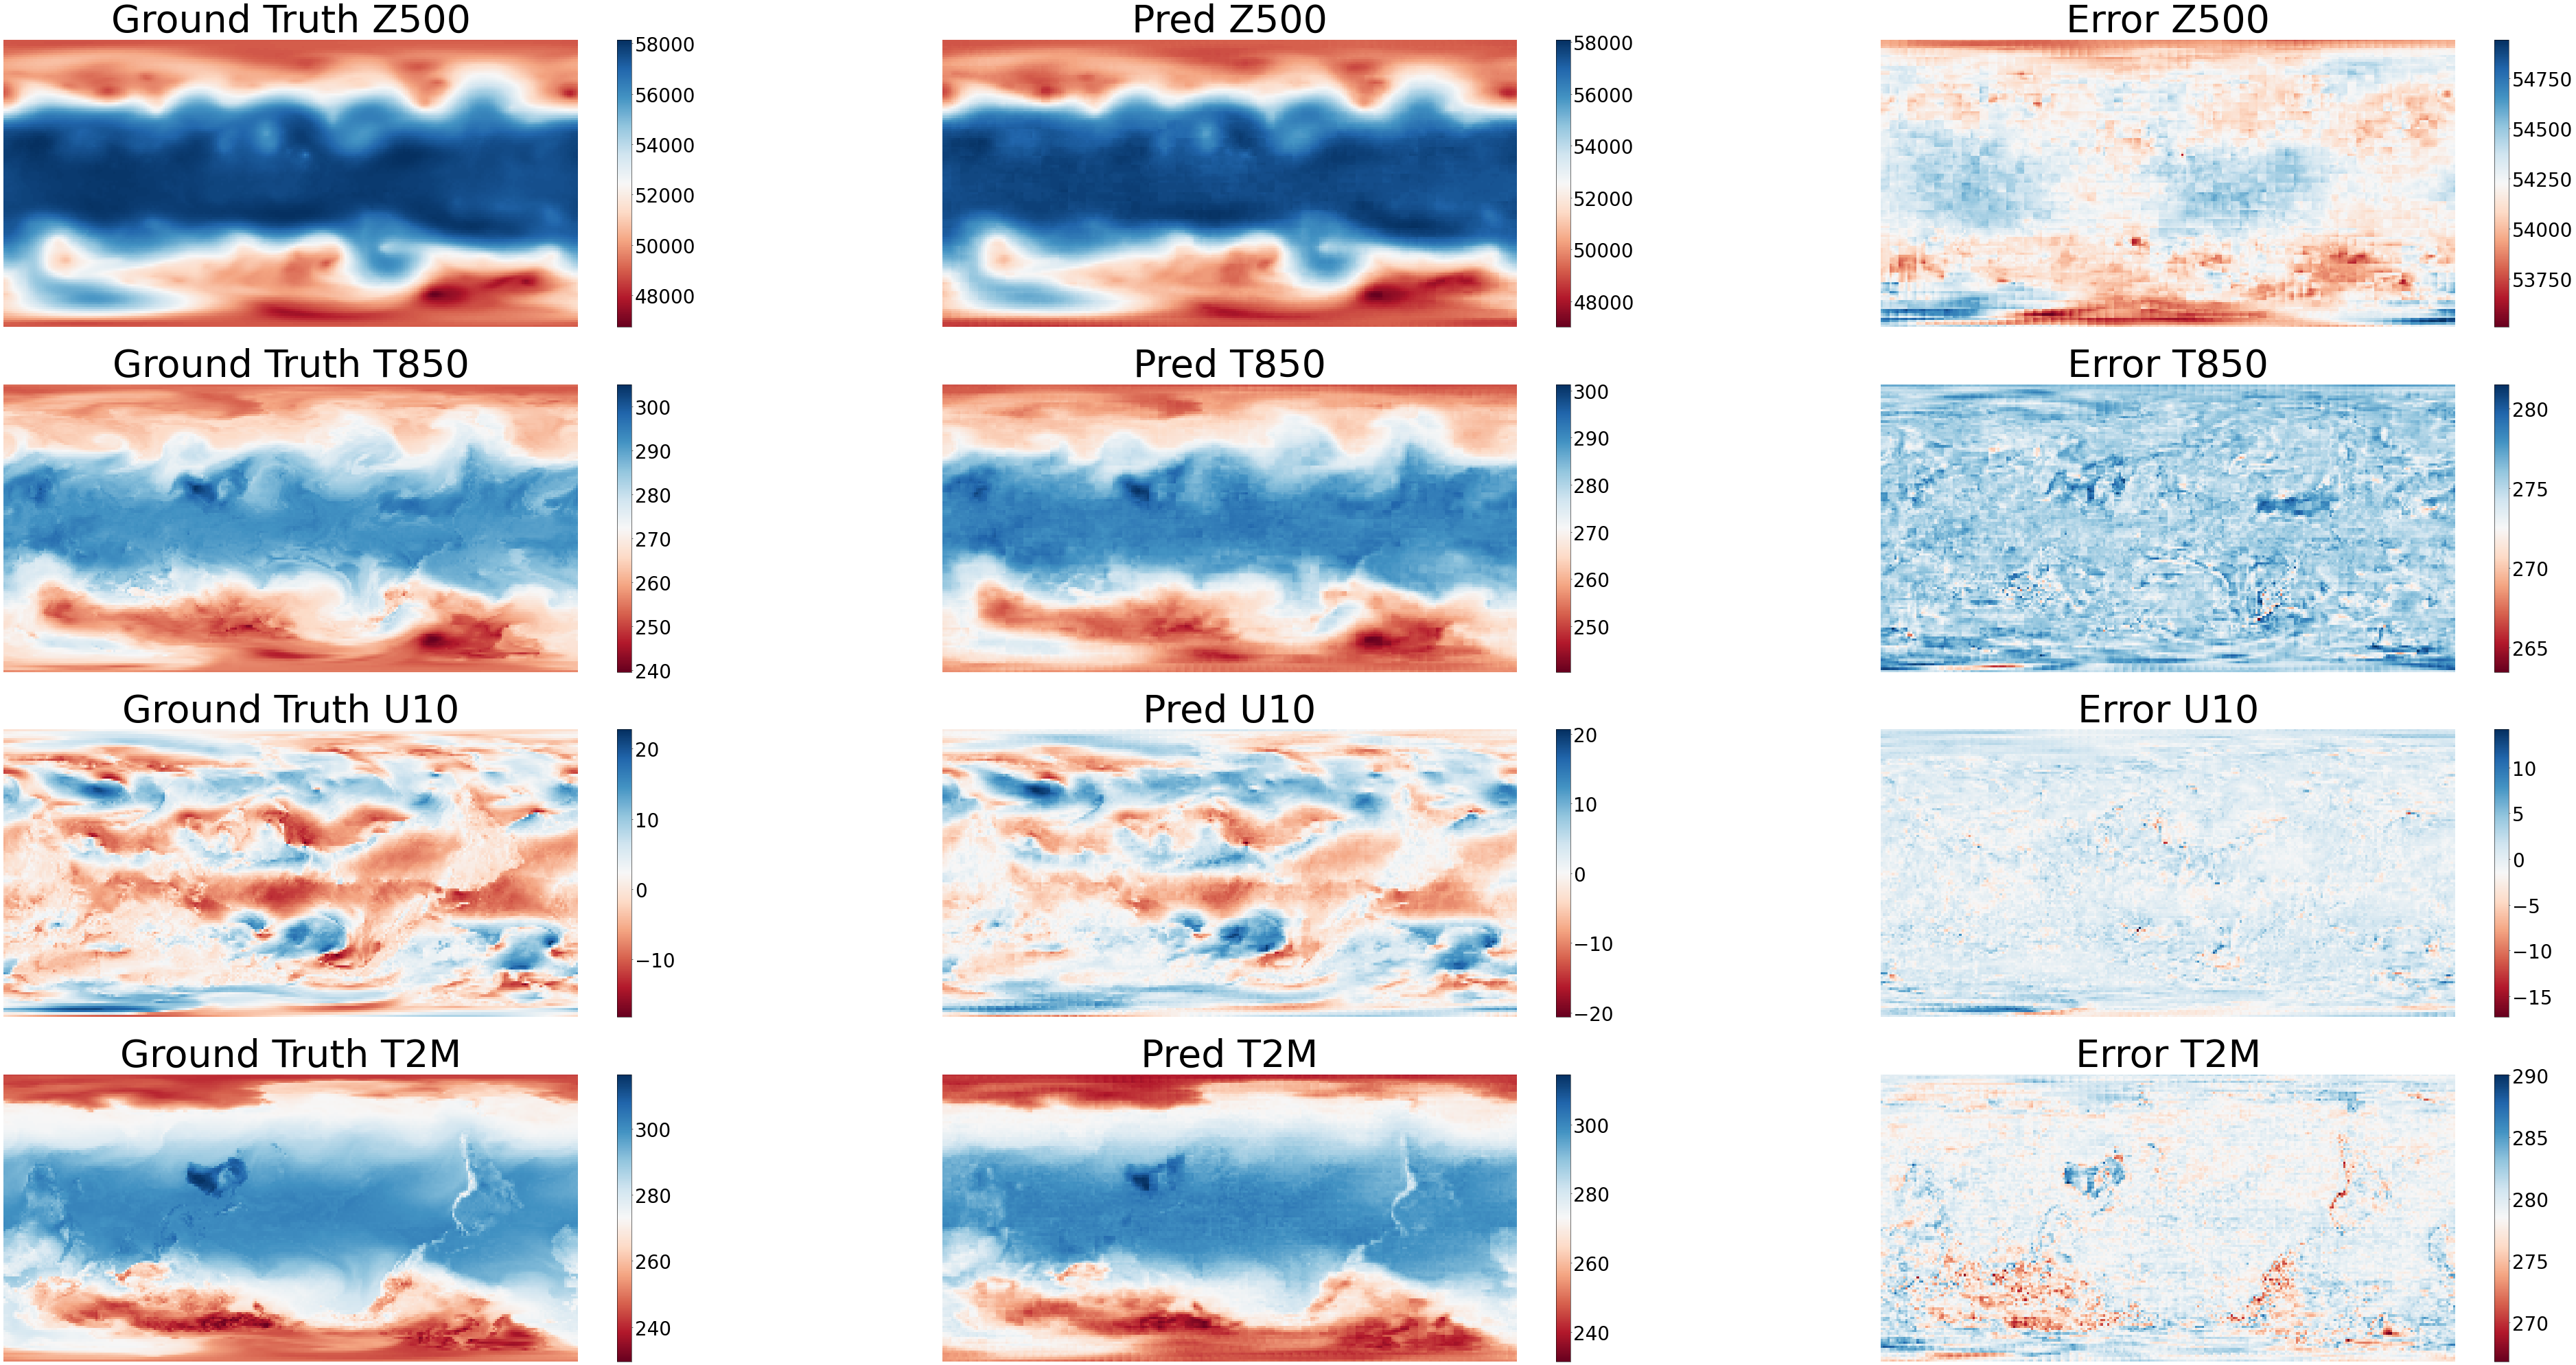

In [ ]:
class ViTKNOEra5Data(Era5Data):
    def _patch(self, *args):
        """ Partition the data into patches. """
        x = args[0]
        if self.run_mode == 'valid' or self.run_mode == 'test':
            x = x.transpose(1, 0, 2, 3)
        return x
test_dataset_generator = ViTKNOEra5Data(data_params=config["data"], run_mode='valid')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']
pred = inference_module.forecast(inputs)
pred = pred[pred_time_index]
ground_truth = labels[..., pred_time_index, :, :].asnumpy()
plt_data(pred, ground_truth, config['data']['root_dir'])